In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

RAW_DIR = Path("..") / "Data"
PROCESSED_DIR = Path("..") / "data" / "processed"

PRICE_SCALE = 10_000.0
LEVELS = 10
ASK_DUMMY = 9_999_999_999
BID_DUMMY = -9_999_999_999

MSG_PATH = RAW_DIR / "GOOG_2012-06-21_34200000_57600000_message_10.csv"
OB_PATH  = RAW_DIR / "GOOG_2012-06-21_34200000_57600000_orderbook_10.csv"

PARQUET_PATH = PROCESSED_DIR / "goog_2012-06-21.parquet"
PICKLE_PATH  = PROCESSED_DIR / "goog_2012-06-21.pkl"


def load_df_standalone(levels: int = LEVELS) -> pd.DataFrame:
    """
    Standalone loader:
    - if processed parquet/pkl exists -> load it
    - else -> read raw CSVs, replace dummy prices & set time index
    """
    if PARQUET_PATH.exists():
        return pd.read_parquet(PARQUET_PATH)
    if PICKLE_PATH.exists():
        return pd.read_pickle(PICKLE_PATH)

    msg_cols = ["time", "type", "order_id", "size", "price", "direction"]
    msg = pd.read_csv(MSG_PATH, header=None, names=msg_cols)

    ob_cols = []
    for lvl in range(1, levels + 1):
        ob_cols += [f"ask_p{lvl}", f"ask_s{lvl}", f"bid_p{lvl}", f"bid_s{lvl}"]
    ob = pd.read_csv(OB_PATH, header=None, names=ob_cols, usecols=list(range(4 * levels)))

    assert len(msg) == len(ob), f"Row mismatch: msg={len(msg)} vs ob={len(ob)}"

    df = pd.concat([msg, ob], axis=1).sort_values("time", kind="mergesort")
    df = df.set_index("time", drop=False)

    ask_price_cols = [f"ask_p{i}" for i in range(1, levels + 1)]
    bid_price_cols = [f"bid_p{i}" for i in range(1, levels + 1)]
    df[ask_price_cols] = df[ask_price_cols].replace(ASK_DUMMY, np.nan)
    df[bid_price_cols] = df[bid_price_cols].replace(BID_DUMMY, np.nan)

    return df


df = load_df_standalone()
df.head()


,time,type,order_id,size,price,direction,ask_p1,ask_s1,bid_p1,bid_s1,...,bid_p9,bid_s9,ask_p10,ask_s10,bid_p10,bid_s10,ask_p1_d,bid_p1_d,spread,mid
time,,,,,,,,,,,,,,,,,,,,,
34200.015105,34200.015105,4,15818974,4,5794000,1,5802300.0,100,5794000.0,496,...,5732000.0,20,5892600.0,100,5700000.0,100,580.23,579.4,0.83,579.815
34200.059902,34200.059902,4,15818974,300,5794000,1,5802300.0,100,5794000.0,196,...,5732000.0,20,5892600.0,100,5700000.0,100,580.23,579.4,0.83,579.815
34200.113247,34200.113247,5,0,1,5795100,1,5802300.0,100,5794000.0,196,...,5732000.0,20,5892600.0,100,5700000.0,100,580.23,579.4,0.83,579.815
34200.113247,34200.113247,5,0,1,5795000,1,5802300.0,100,5794000.0,196,...,5732000.0,20,5892600.0,100,5700000.0,100,580.23,579.4,0.83,579.815
34200.113247,34200.113247,5,0,1,5794900,1,5802300.0,100,5794000.0,196,...,5732000.0,20,5892600.0,100,5700000.0,100,580.23,579.4,0.83,579.815


In [14]:
# Top-of-book validity
valid_top = df["ask_p1"].notna() & df["bid_p1"].notna()

# Mid & spread
df["mid_d"] = np.nan
df.loc[valid_top, "mid_d"] = (df.loc[valid_top, "ask_p1"] + df.loc[valid_top, "bid_p1"]) / (2 * PRICE_SCALE)

df["spread_d"] = np.nan
df.loc[valid_top, "spread_d"] = (df.loc[valid_top, "ask_p1"] - df.loc[valid_top, "bid_p1"]) / PRICE_SCALE

# Next-event mid change
df["dmid_1"] = df["mid_d"].shift(-1) - df["mid_d"]

# FI L1 (event-based)
bp, bs = df["bid_p1"], df["bid_s1"]
ap, aS = df["ask_p1"], df["ask_s1"]

bp_prev, bs_prev = bp.shift(1), bs.shift(1)
ap_prev, aS_prev = ap.shift(1), aS.shift(1)

bid_contrib = np.where(bp > bp_prev, bs,
               np.where(bp < bp_prev, -bs_prev,
               (bs - bs_prev)))

ask_contrib = np.where(ap < ap_prev, aS,
               np.where(ap > ap_prev, -aS_prev,
               (aS - aS_prev)))

df["ofi_l1"] = bid_contrib - ask_contrib
depth_l1 = (df["bid_s1"] + df["ask_s1"]).replace(0, np.nan)
df["ofi_l1_norm"] = df["ofi_l1"] / depth_l1


# Analysis table
tmp = df.loc[valid_top, ["ofi_l1", "ofi_l1_norm", "dmid_1", "spread_d"]].dropna()

# Sanity checks
neg_share = (tmp["spread_d"] < 0).mean()
assert neg_share < 1e-6, f"Negative spread share too high: {neg_share:.2e}"
assert (tmp["spread_d"] >= 0).mean() > 0.999999
print("Rows used:", len(tmp))
tmp[["ofi_l1", "dmid_1", "spread_d"]].describe()



Rows used: 147914


,ofi_l1,dmid_1,spread_d
count,147914.000000,147914.000000,147914.000000
mean,0.149073,-0.000099,0.296239
std,61.257126,0.024587,0.148134
min,-2300.000000,-0.970000,0.010000
25%,0.000000,0.000000,0.200000
50%,0.000000,0.000000,0.280000
75%,0.000000,0.000000,0.360000
max,2171.000000,0.970000,2.310000


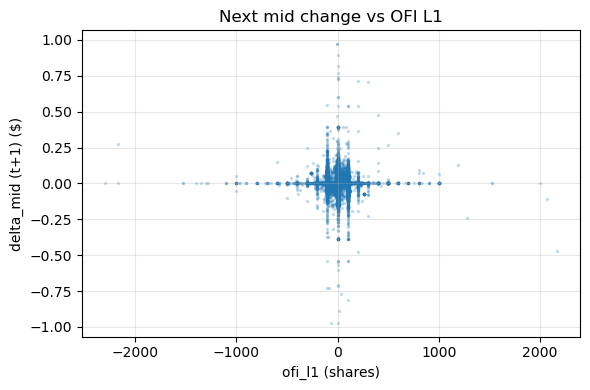

Corr(ofi_l1, dmid_1): -0.06608935953565861


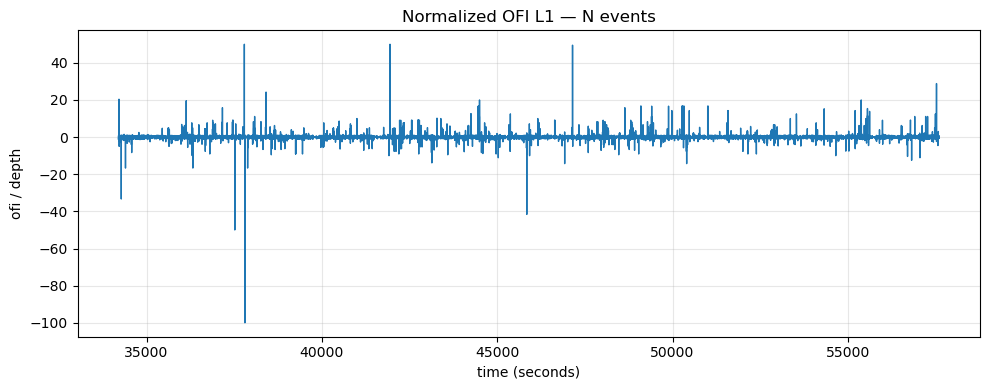

In [16]:
N = 200_000
s = tmp.head(N)

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(s["ofi_l1"], s["dmid_1"], s=2, alpha=0.2)
ax.set_title("Next mid change vs OFI L1")
ax.set_xlabel("ofi_l1 (shares)")
ax.set_ylabel("delta_mid (t+1) ($)")
ax.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()

print("Corr(ofi_l1, dmid_1):", s["ofi_l1"].corr(s["dmid_1"]))

# Ofi normalized
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(tmp.index[:N], tmp["ofi_l1_norm"].iloc[:N], linewidth=1)
ax.set_title("Normalized OFI L1 — N events")
ax.set_xlabel("time (seconds)")
ax.set_ylabel("ofi / depth")
ax.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()
